# Sentiment Analysis

## Dependencies

In [1]:
# Fetch saved model if needed
#!wget -O ./'Sentiment Analysis'/ignore/Baseline_RF_Sentiment_4.0.E/saved_model1.joblib https://storage.googleapis.com/dionricky-static/baseline_rf_4.0.E.joblib

In [2]:
import os
import re
from joblib import load, dump

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from util.model_helper import Model, ModelLoader
from util.ensemble_helper import ModelConcatenate, VotingEnsemble, \
    StackingEnsemble

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Configs

In [3]:
sklearn_loader = load
keras_loader = keras.models.load_model

In [4]:
BASE_DIR = os.path.join('Sentiment Analysis')

In [5]:
dt_config = {
    "name": "Decission Tree",
    "shortname": "DT",
    "path": os.path.join(BASE_DIR, "Baseline",
                        "Baseline_DT_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

rf_config = {
    "name": "Random Forest",
    "shortname": "RF",
    "path": os.path.join(BASE_DIR, "ignore",
                        "Baseline_RF_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

lr_config = {
    "name": "Logistic Regression",
    "shortname": "LR",
    "path": os.path.join(BASE_DIR, "Baseline",
                        "Baseline_LR_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

nb_config = {
    "name": "Naive Bayes",
    "shortname": "NB",
    "path": os.path.join(BASE_DIR, "Baseline",
                        "Baseline_NB_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

nc_config = {
    "name": "Nearest Centroid",
    "shortname": "NC",
    "path": os.path.join(BASE_DIR, "Baseline",
                        "Baseline_NC_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

svm_config = {
    "name": "Support Vector Machine",
    "shortname": "SVM",
    "path": os.path.join(BASE_DIR, "Baseline",
                        "Baseline_SVM_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

knn_config = {
    "name": "K Nearest Neighbor",
    "shortname": "KNN",
    "path": os.path.join(BASE_DIR, "Baseline",
                        "Baseline_KNN_Sentiment_4.0.E", "saved_model.joblib"),
    "version": "4.0.E",
    "loader": sklearn_loader
}

lstm_config = {
    "name": "Long Short-term Memory",
    "shortname": "LSTM",
    "path": os.path.join(BASE_DIR, "LSTM", "LSTM_Sentiment_4.0.E"),
    "version": "4.0.E",
    "loader": keras_loader
}

cnn_config = {
    "name": "Convolutional Neural Network",
    "shortname": "CNN",
    "path": os.path.join(BASE_DIR, "CNN", "CNN_Sentiment_5.0"),
    "version": "5.0.E",
    "loader": keras_loader
}

## Load Tokenizer

In [6]:
tokenizer_path = os.path.join(BASE_DIR, 'Tokenizer', 'tokens_30k.json')
tokenizer_file = open(tokenizer_path, 'r')

TOKENIZER = tokenizer_from_json(tokenizer_file.read())

tokenizer_file.close()

## Utils

In [7]:
# class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
#   def get_stop_word(self):
#     new_sw = ["ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai","berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui","diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui","melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"]
#     new_sw.extend(super().get_stop_words())
#     return list(set(new_sw))

# sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

In [8]:
def extract_emojis(sentence):
    return [word for word in sentence.split() if str(word.encode('unicode-escape'))[2] == '\\' ]

In [9]:
def preprocessing_text(text):
    if type(text) == list \
        or type(text) == np.ndarray \
        or type(text) == pd.Series:
        return [preprocessing_text(t) for t in text]

    emojis = ' '.join(extract_emojis(text))
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()

    return text + emojis

In [10]:
def keras_preprocess(texts, vector_size=120):
    texts = texts if type(texts) != str else [texts]
    texts = preprocessing_text(texts)
    seq = TOKENIZER.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=vector_size, padding='post')

In [11]:
def sklearn_preprocess(texts):
    texts = texts if type(texts) != str else [texts]
    texts = preprocessing_text(texts)
    return texts

## Load Models

In [12]:
# Load Models
DT = ModelLoader(**dt_config)
DT = Model(
        model=DT.load(),
        pred_func= lambda m, x: m.predict_proba(sklearn_preprocess(x)),
        **DT.get_config())

RF = ModelLoader(**rf_config)
RF = Model(
        model=RF.load(),
        pred_func= lambda m, x: m.predict_proba(sklearn_preprocess(x)),
        **RF.get_config())

LR = ModelLoader(**lr_config)
LR = Model(
        model=LR.load(),
        pred_func= lambda m, x: m.predict_proba(sklearn_preprocess(x)),
        **LR.get_config())

NB = ModelLoader(**nb_config)
NB = Model(
        model=NB.load(),
        pred_func= lambda m, x: m.predict_proba(sklearn_preprocess(x)),
        **NB.get_config())

NC = ModelLoader(**nc_config)
NC = Model(
        model=NC.load(),
        pred_func=lambda m, x: m.predict(sklearn_preprocess(x)),
        calc_proba_func=lambda y: np.array([1-y, y]).transpose(),
        **NC.get_config())

SVM = ModelLoader(**svm_config)
SVM = Model(
        model=SVM.load(),
        pred_func=lambda m, x: m.predict(sklearn_preprocess(x)),
        calc_proba_func=lambda y: np.array([1-y, y]).transpose(),
        **SVM.get_config())

KNN = ModelLoader(**knn_config)
KNN = Model(
        model=KNN.load(),
        pred_func=lambda m, x: m.predict_proba(sklearn_preprocess(x)),
        **KNN.get_config())

LSTM = ModelLoader(**lstm_config)
LSTM = Model(
        model=LSTM.load(),
        pred_func= lambda m, x: m.predict( keras_preprocess(x), workers=2 ),
        post_process=lambda y: y.reshape(y.shape[0]),
        calc_proba_func=lambda y: np.array([1-y, y]).transpose(),
        **LSTM.get_config())

CNN = ModelLoader(**cnn_config)
CNN = Model(
        model=CNN.load(),
        pred_func=lambda m, x: m.predict( keras_preprocess(x), workers=2 ),
        post_process=lambda y: y.reshape(y.shape[0]),
        calc_proba_func=lambda y: np.array([1-y, y]).transpose(),
        **CNN.get_config())

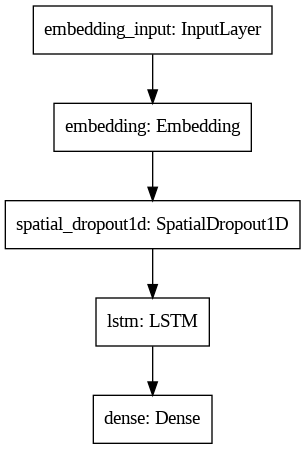

In [18]:
keras.utils.plot_model(LSTM.model)

## Concatenating Models

In [13]:
concat = ModelConcatenate([DT, RF, LR, NB, NC, SVM, KNN, LSTM, CNN])

In [14]:
ensemble = VotingEnsemble(concat)

## Ensemble

### Fetching Data

In [15]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [16]:
# query = """
# SELECT * FROM `future-data-track-1.sapporo_mart.sampled_sentiment_analysis`;
# """

# query = """
# SELECT
#     review,
#     CASE
#         WHEN rating < 3 THEN 0
#         WHEN rating > 3 THEN 2
#     ELSE 1
#     END AS sentiment
# FROM `future-data-track-1.sapporo_mart.app_reviews`
# WHERE rating != 3
# 	AND EXTRACT(MONTH FROM created_date) = 1
# 	AND EXTRACT(YEAR FROM created_date) = 2022;
# """

query = """
SELECT * FROM `future-data-track-1.sapporo_mart.test_case`;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [17]:
df = df.dropna(axis=0)

### Preprocessing

In [18]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [19]:
df.head()

,review_id,review,rating,sentiment,review_cleaned
0,gp:AOqpTOGRJc9vClb7RwqODHTtLiINySdHEBc01d9-TnH...,Saya rugi besar di lazada ketika return barang...,1,0,rugi lazada return barang uang intinya kecewa ...
1,gp:AOqpTOG94r6DiHB-YEbyqVxEZLqIcqio4E68TR7Gv3W...,Shoopeee kontolll kadang lag parah,1,0,shoopeee kontolll kadang lag parah
2,gp:AOqpTOEtKB2NpwpOaFHrgWHerrk3n9c1KXjdXsKlHa9...,Ga bisa update,1,0,ga update
3,gp:AOqpTOERAxmNOpY6sviySoLlcXS32PTRcaOUobmwyT8...,Tokopedia anj Tokopedia gblk Tokopedia anak haram,1,0,tokopedia anj tokopedia gblk tokopedia anak haram
4,gp:AOqpTOEiroYqUcztzg0fV3uVbNC72NN99g9MwiGQ1GP...,Iklan anjg,1,0,iklan anjg


In [20]:
df['sentiment'] = df['sentiment'].map({0:0, 2:1})

### Splitting Data

In [59]:
# X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])

In [21]:
X_test = df['review_cleaned']
y_test = df['sentiment']

### Evaluating Model

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      5000
           1       0.81      0.85      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



<AxesSubplot:>

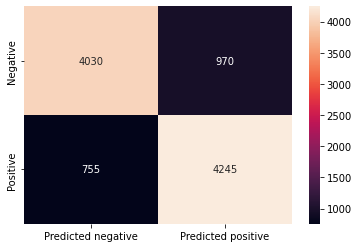

In [22]:
y_pred = np.argmax(LSTM.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      5000
           1       0.83      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



<AxesSubplot:>

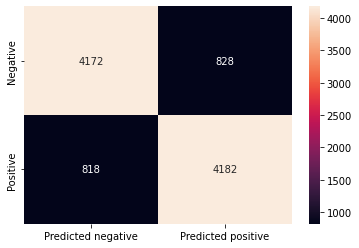

In [23]:
y_pred = ensemble.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Exporting For Production

In [24]:
model_concat_configs = [dt_config, rf_config, lr_config, nb_config, nc_config,
                        svm_config, knn_config, lstm_config, cnn_config]

In [35]:
BASE_PROJECT_DIR = os.path.join('/home', 'dionrickysptr', 'future-data-2')
BASE_DS_DIR = os.path.join(BASE_PROJECT_DIR, 'data science',)
BASE_SENTIMENT_DIR = os.path.join(BASE_DS_DIR, 'Sentiment Analysis')
BASE_PROD_DIR = os.path.join(BASE_SENTIMENT_DIR, 'dist')

### Creating Symlink in Prod Folder

In [36]:
for model in model_concat_configs:
    model_sn = model['shortname']
    model_version = model['version']
    model_path = model['path']
    model_path = os.path.join(BASE_DS_DIR, model_path)

    dest = '_'.join([model_sn, model_version])
    dest = os.path.join(BASE_PROD_DIR, dest)

    os.symlink(model_path, dest)

In [39]:
exported_config = []

for model in model_concat_configs:
    model_sn = model['shortname']
    model_version = model['version']

    model_exported_name = '_'.join([model_sn, model_version])

    config = {
        'name': model['name'],
        'shortname': model_sn,
        'version': model_version,
        'exported_name': model_exported_name
    }

    exported_config.append(config)

### Dumping Exported Model Configs

In [41]:
import json

In [44]:
with open(os.path.join(BASE_PROD_DIR, 'configs.json'), 'w+') as _f:
    json.dump(exported_config, _f)